In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
pd.options.display.max_columns = 999

from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 as chi2_2

In [2]:
# Load the business dataframe
df = pd.read_csv('yelp_restaurants.csv')

In [3]:
# Select attribute column names
attribute_col = [col for col in df.columns if 'attribute' in col]

In [4]:
attribute_col

['attributes.RestaurantsTableService',
 'attributes.WiFi',
 'attributes.BikeParking',
 'attributes.BusinessAcceptsCreditCards',
 'attributes.RestaurantsReservations',
 'attributes.WheelchairAccessible',
 'attributes.Caters',
 'attributes.OutdoorSeating',
 'attributes.RestaurantsGoodForGroups',
 'attributes.HappyHour',
 'attributes.RestaurantsPriceRange2',
 'attributes.HasTV',
 'attributes.Alcohol',
 'attributes.DogsAllowed',
 'attributes.RestaurantsTakeOut',
 'attributes.NoiseLevel',
 'attributes.RestaurantsAttire',
 'attributes.RestaurantsDelivery',
 'attributes.GoodForKids',
 'attributes.garage',
 'attributes.street',
 'attributes.validated',
 'attributes.lot',
 'attributes.valet',
 'attributes.touristy',
 'attributes.hipster',
 'attributes.romantic',
 'attributes.divey',
 'attributes.intimate',
 'attributes.trendy',
 'attributes.upscale',
 'attributes.classy',
 'attributes.casual',
 'attributes.dessert',
 'attributes.latenight',
 'attributes.lunch',
 'attributes.dinner',
 'attribute

# Feature Selection (Attribute columns)

## Filter based method - Chi Square Test for Independence

In [4]:
# Create a dataframe for 'open' and 'closed' restaurants' attributes
df_att_isclosed = df[df['is_open'] == 0][['is_open'] + attribute_col]
df_att_isopen = df[df['is_open'] == 1][['is_open'] + attribute_col]

In [5]:
# Replace 0 and 1 with 'closed' and 'open' respectively
df_att_isclosed.is_open.replace(to_replace=0, value='Closed', inplace=True)
df_att_isopen.is_open.replace(to_replace=1, value='Open', inplace=True)

Ho: There is no association/relation between the 'is_open' and the selected attribute.

Ha: There is an association/relation between the 'is_open' and the selected attribute.

Reject Null Hypothesis if p-value < 0.05 and chi statistic > critical value.

In [6]:
# Define a function to calculate chi2 critical value
def chi2_critical(dof):
    value = chi2.ppf(0.95, dof)
    return value

In [7]:
# Chi square test for independence
fail_to_reject = []
for col in attribute_col:
    
    # Prepare dataframe for chi2 independence test
    df_chi2 = pd.crosstab(df['is_open'], df[col])

    # Run chi2 contingency
    chi, p_val, dof, exp = chi2_contingency(df_chi2)
    critical = chi2_critical(dof)
    
    # Chi2 for independence requires expected value (observed frequency) of more than 5
    df_chi2b = pd.DataFrame(exp, index=df_chi2.index, columns=df_chi2.columns)
    
    # Print expected value of less than 5 columns and break if there's any
    cols_keep = df_chi2b[df_chi2b > 5].dropna(axis=1).columns.tolist()
    cols_combine = [col for col in df_chi2b.columns if col not in cols_keep]
    
    if len(cols_combine) > 1:
        print('Failed to run chi2 independence test for {}'.format(col))
        break
    
    col_string = col.replace('attributes.', '')
    
    # Test against hypothesis
    if ((p_val < 0.05) & (chi > critical)):
        print(col_string, 'has p-value of %.3f' % p_val, 
              'and Chi-square %.3f > Critical %.3f' % (chi, critical), '\n' +
              'Reject Null Hypothesis for', col_string, '\n')
    else:
        print(col_string, 'has p-value of %.3f' % p_val, 
              'and Chi-square %.3f < Critical %.3f' % (chi, critical), '\n' +
              'Fail to Reject Null Hypothesis for', col_string, '\n')
        fail_to_reject.append(col)

RestaurantsTableService has p-value of 0.000 and Chi-square 1460.747 > Critical 5.991 
Reject Null Hypothesis for RestaurantsTableService 

WiFi has p-value of 0.000 and Chi-square 582.249 > Critical 7.815 
Reject Null Hypothesis for WiFi 

BikeParking has p-value of 0.000 and Chi-square 3661.477 > Critical 5.991 
Reject Null Hypothesis for BikeParking 

BusinessAcceptsCreditCards has p-value of 0.000 and Chi-square 83.231 > Critical 5.991 
Reject Null Hypothesis for BusinessAcceptsCreditCards 

RestaurantsReservations has p-value of 0.000 and Chi-square 657.233 > Critical 5.991 
Reject Null Hypothesis for RestaurantsReservations 

WheelchairAccessible has p-value of 0.000 and Chi-square 1856.350 > Critical 5.991 
Reject Null Hypothesis for WheelchairAccessible 

Caters has p-value of 0.000 and Chi-square 1024.394 > Critical 5.991 
Reject Null Hypothesis for Caters 

OutdoorSeating has p-value of 0.000 and Chi-square 1500.517 > Critical 5.991 
Reject Null Hypothesis for OutdoorSeating 

In [8]:
# Did any of the Chi2 test fail to reject null hypothesis?
print(fail_to_reject)

[]


## Post Hoc Test

Comparing multiple classes against each other would means that the error rate of a false positive compound with each test. For example, if we choose our first test at p-value level 0.05 means there is a 5% chance of a false positive; if we have multiple classes, the test after that would compounding the error with the chance become 10% of a false positive, and so forth. With each subsequent test, the error rate would increase by 5%. (https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43). In our case above, we had 3 pairwise comparisons. This means that our Chi-square test would have an error rate of 15%. Meaning our p-value being tested at would equal 0.15, which is quite high.
In this case, we could use the Bonferroni-adjusted method for correcting the p-value we use. We adjust our P-value by the number of pairwise comparisons we want to do. The formula is p/N, where p= the p-value of the original test and N= the number of planned pairwise comparisons. 

### Bonferroni Correction Method
Bonferroni-correlated p-value = The original p-value / Number of tests performed

In [9]:
# Chi square test for independence
fail_to_reject = []
for col in attribute_col:
    
    # Prepare dataframe for chi2 independence test
    df_chi2 = pd.crosstab(df['is_open'], df[col])

    # Run chi2 contingency
    chi, p_val, dof, exp = chi2_contingency(df_chi2)
    critical = chi2_critical(dof)
    
    # Chi2 for independence requires expected value (observed frequency) of more than 5
    df_chi2b = pd.DataFrame(exp, index=df_chi2.index, columns=df_chi2.columns)
    
    # Print expected value of less than 5 columns and break if there's any
    cols_keep = df_chi2b[df_chi2b > 5].dropna(axis=1).columns.tolist()
    cols_combine = [col for col in df_chi2b.columns if col not in cols_keep]
    
    if len(cols_combine) > 1:
        print('Failed to run chi2 independence test for {}'.format(col))
        break
    
    col_string = col.replace('attributes.', '')
  
    # Define Bonferroni-correlated p-value
    bon_p = 0.05 / df[col].nunique()
    
    # Test against hypothesis
    if ((p_val < bon_p) & (chi > critical)):
        print(col_string, 'has p-value of %.3f' % p_val, 
              'and Chi-square %.3f > Critical %.3f' % (chi, critical), '\n' +
              'Reject Null Hypothesis for', col_string, '\n')
    else:
        print(col_string, 'has p-value of %.3f' % p_val, 
              'and Chi-square %.3f < Critical %.3f' % (chi, critical), '\n' +
              'Fail to Reject Null Hypothesis for', col_string, '\n')
        fail_to_reject.append(col)

RestaurantsTableService has p-value of 0.000 and Chi-square 1460.747 > Critical 5.991 
Reject Null Hypothesis for RestaurantsTableService 

WiFi has p-value of 0.000 and Chi-square 582.249 > Critical 7.815 
Reject Null Hypothesis for WiFi 

BikeParking has p-value of 0.000 and Chi-square 3661.477 > Critical 5.991 
Reject Null Hypothesis for BikeParking 

BusinessAcceptsCreditCards has p-value of 0.000 and Chi-square 83.231 > Critical 5.991 
Reject Null Hypothesis for BusinessAcceptsCreditCards 

RestaurantsReservations has p-value of 0.000 and Chi-square 657.233 > Critical 5.991 
Reject Null Hypothesis for RestaurantsReservations 

WheelchairAccessible has p-value of 0.000 and Chi-square 1856.350 > Critical 5.991 
Reject Null Hypothesis for WheelchairAccessible 

Caters has p-value of 0.000 and Chi-square 1024.394 > Critical 5.991 
Reject Null Hypothesis for Caters 

OutdoorSeating has p-value of 0.000 and Chi-square 1500.517 > Critical 5.991 
Reject Null Hypothesis for OutdoorSeating 

In [10]:
# Did any of the Bonferroni Corrected Chi2 test fail to reject null hypothesis?
print(fail_to_reject)

[]


# Possible Multicolinearity

Since all features Reject Null Hypothesis for Chi2 Test for Independence, let's see if there are possible multicolinearity between the features

### Heatmap correlation between attribute columns

LabelEncoding will be used the display the correlation between the columns consisting of "true, false, none, or not listed". The initial guess is that the attribute columns such as romantic and intimate, and dj and music will show high correlation. It is assumed here that the restaurant owners would've selected correlating attributes to either True or False.

In [11]:
# Instantiate LabelEncoder
le = preprocessing.LabelEncoder()

In [12]:
# Create a copy of the business dataframe
b_copy = df.copy()

In [13]:
# Search for columns with values of 'true, false, none, or not listed'
lst = []

for col in attribute_col:
    if all(df[col].str.contains('true|false|none|not listed', flags=re.IGNORECASE)):
        lst.append(col)

In [14]:
# Whats in lst?
lst

['attributes.RestaurantsTableService',
 'attributes.BikeParking',
 'attributes.BusinessAcceptsCreditCards',
 'attributes.RestaurantsReservations',
 'attributes.WheelchairAccessible',
 'attributes.Caters',
 'attributes.OutdoorSeating',
 'attributes.RestaurantsGoodForGroups',
 'attributes.HappyHour',
 'attributes.HasTV',
 'attributes.DogsAllowed',
 'attributes.RestaurantsTakeOut',
 'attributes.RestaurantsDelivery',
 'attributes.GoodForKids',
 'attributes.garage',
 'attributes.street',
 'attributes.validated',
 'attributes.lot',
 'attributes.valet',
 'attributes.touristy',
 'attributes.hipster',
 'attributes.romantic',
 'attributes.divey',
 'attributes.intimate',
 'attributes.trendy',
 'attributes.upscale',
 'attributes.classy',
 'attributes.casual',
 'attributes.dessert',
 'attributes.latenight',
 'attributes.lunch',
 'attributes.dinner',
 'attributes.brunch',
 'attributes.breakfast']

In [15]:
# Encode labels in lst
for col in lst:
    b_copy.loc[:, col] = le.fit_transform(b_copy.loc[:, col])

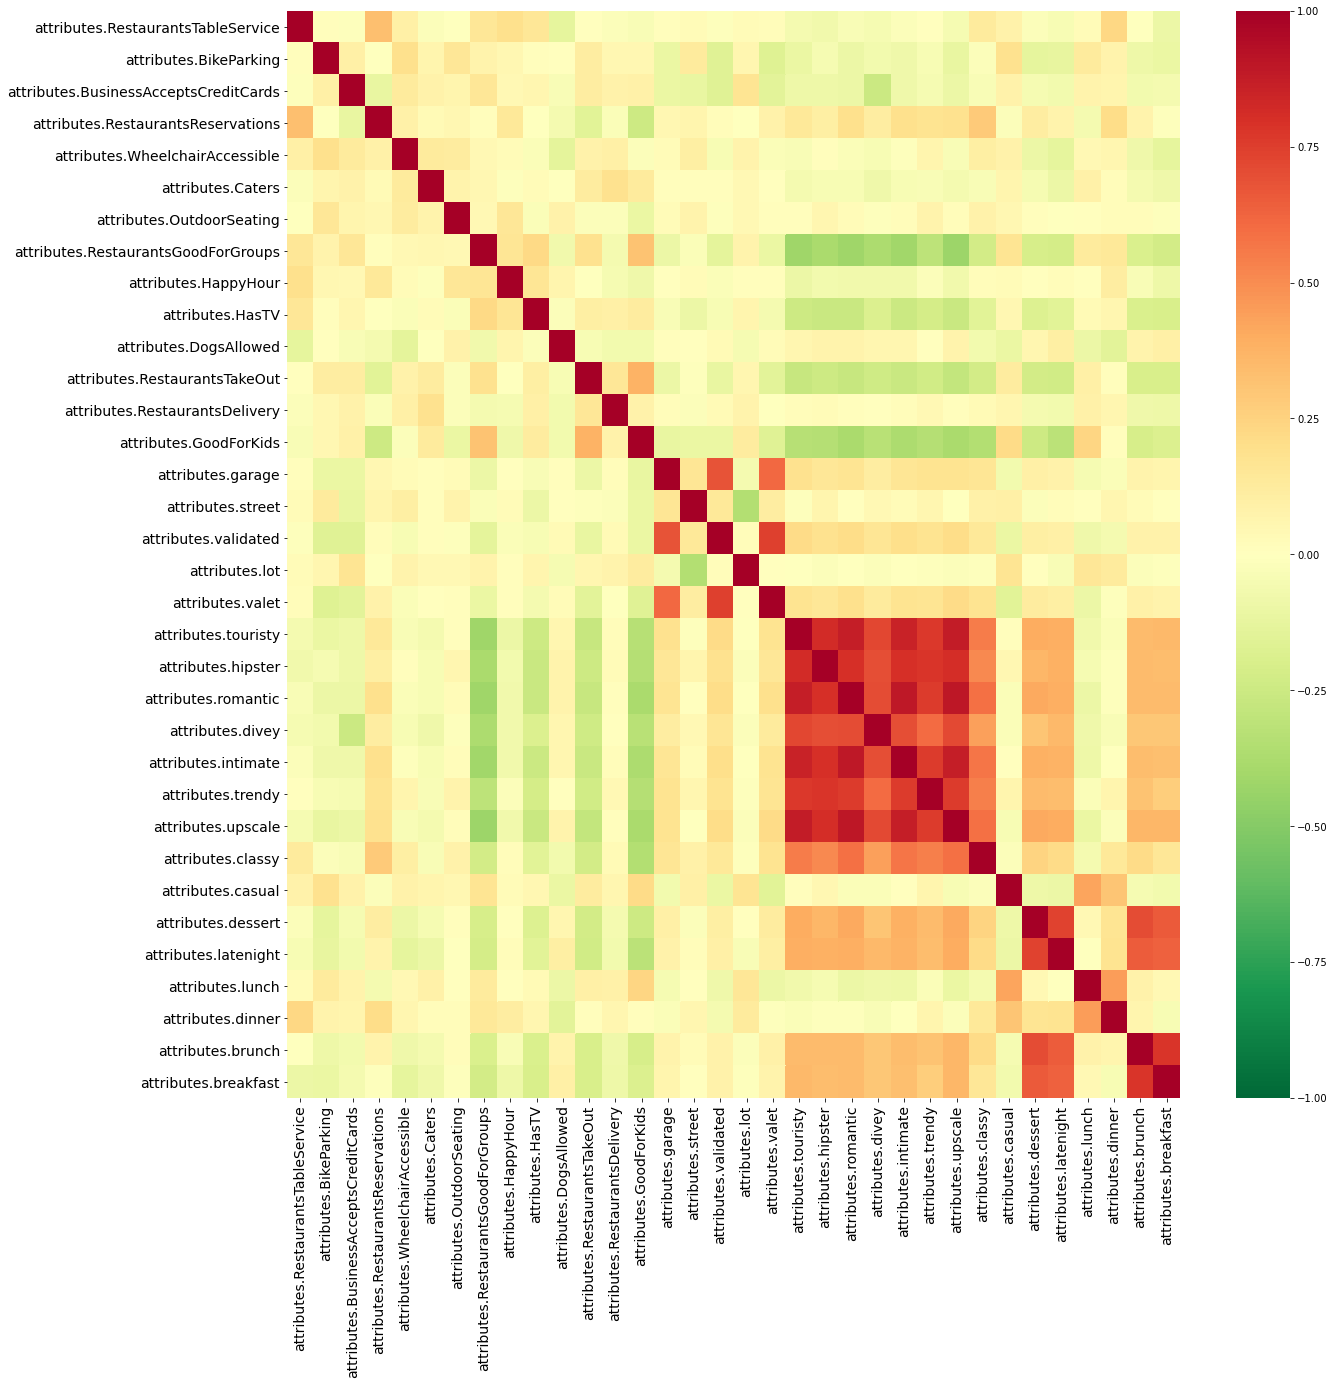

In [16]:
# Plot heat map
plt.figure(figsize=(20,20))
sns.heatmap(b_copy[lst].corr(method='spearman'), vmin=-1, vmax=1, cmap="RdYlGn_r")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

As shown from above features, we can see strong positive correlations between: 
- Brunch and Breakfast
- Intimate and Romantic
- Upscale and Romantic
- Trendy and Hipster
- Etc..

Also, we can see weak negative correlations between:
- Late night and Good for Kids
- Classy and Good for Kids
- Upscale and Takeout
- Romantic and Takeout
- Parking Street and Parking Lot
- Etc..

##### Chances are if the correlation is greater than 0.8, multicolinearity is likely to be present

In [17]:
# Get correlations of each attribute features in dataset
corrmat = b_copy[lst].corr(method='spearman')

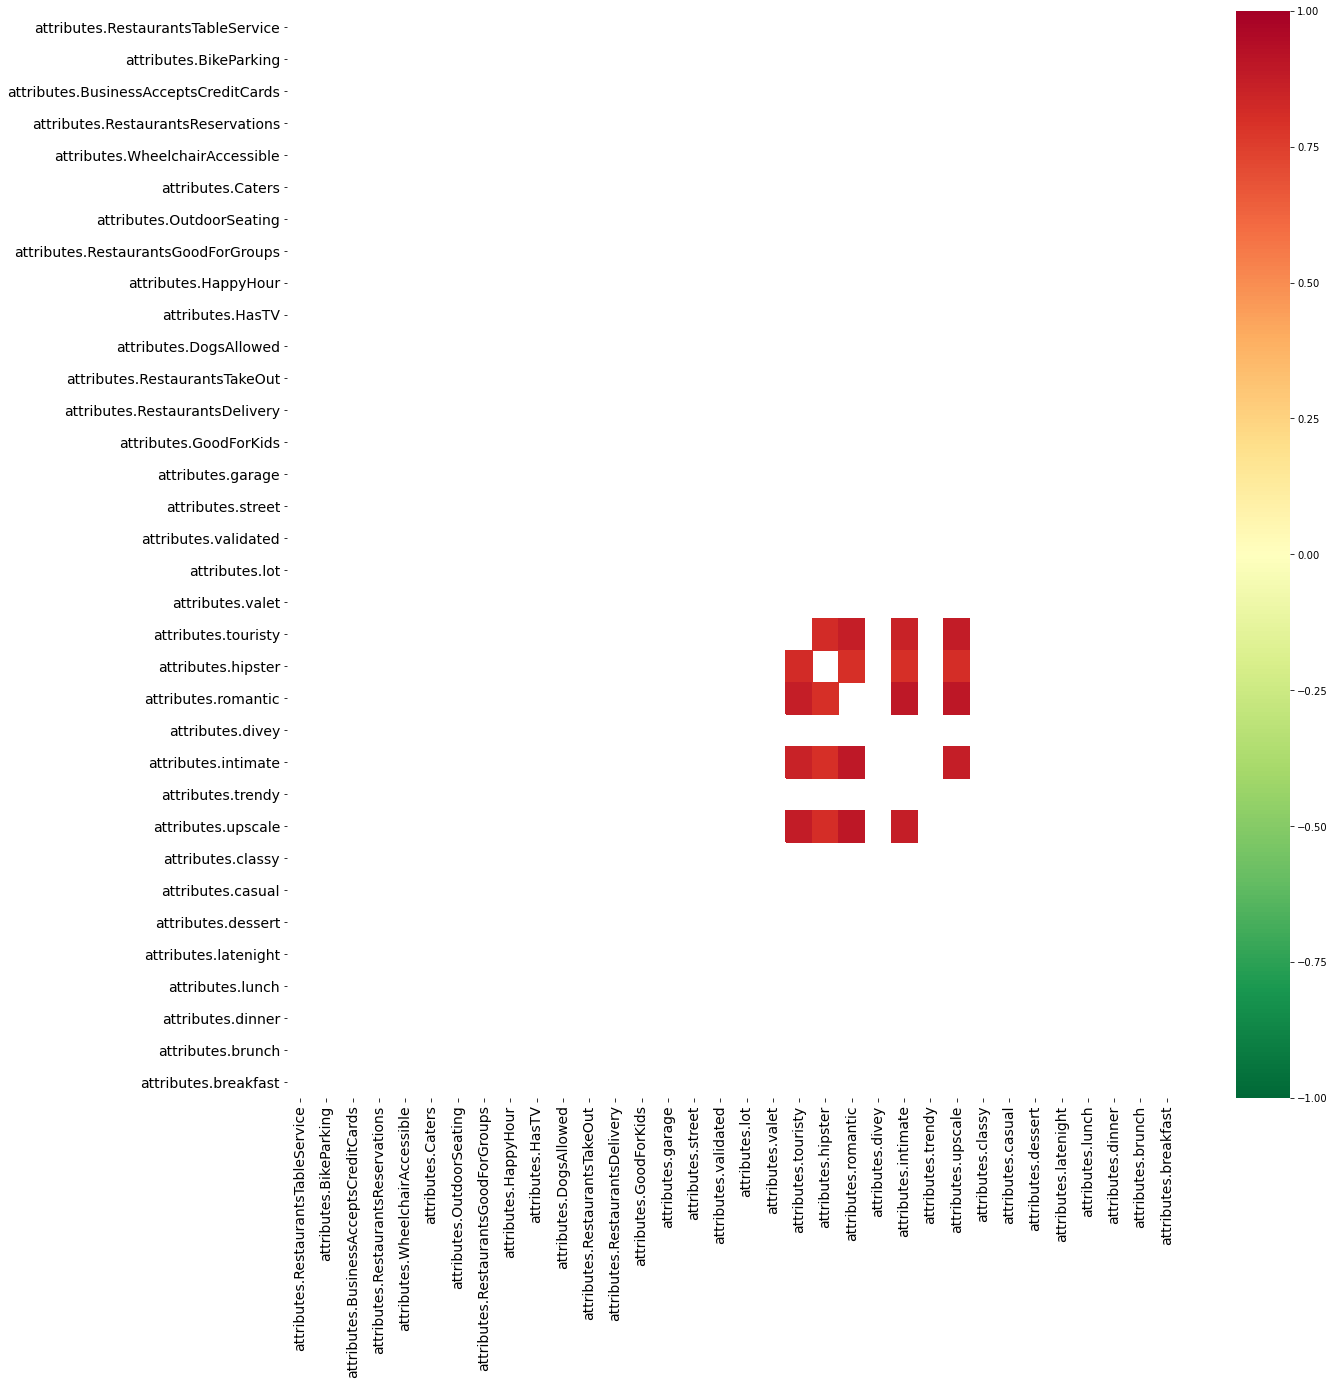

In [18]:
# Plot heat map with correlation >= 0.8
plt.figure(figsize=(20,20))
sns.heatmap(corrmat[(corrmat >= 0.8) & (corrmat != 1)], vmin=-1, vmax=1, cmap="RdYlGn_r")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [19]:
# Which columns have greater than 0.8 corr coef?
corrmat[(corrmat >= 0.8) & (corrmat != 1)].sum() > 0

attributes.RestaurantsTableService       False
attributes.BikeParking                   False
attributes.BusinessAcceptsCreditCards    False
attributes.RestaurantsReservations       False
attributes.WheelchairAccessible          False
attributes.Caters                        False
attributes.OutdoorSeating                False
attributes.RestaurantsGoodForGroups      False
attributes.HappyHour                     False
attributes.HasTV                         False
attributes.DogsAllowed                   False
attributes.RestaurantsTakeOut            False
attributes.RestaurantsDelivery           False
attributes.GoodForKids                   False
attributes.garage                        False
attributes.street                        False
attributes.validated                     False
attributes.lot                           False
attributes.valet                         False
attributes.touristy                       True
attributes.hipster                        True
attributes.ro

In [20]:
# Pick the best feature using chi2 as the score function
pick_best = ['attributes.touristy', 'attributes.hipster', 'attributes.romantic', 'attributes.intimate', 'attributes.upscale']

In [21]:
# Set X and y for SelectKBest
X = b_copy[pick_best]
y = b_copy['is_open']

We will select best feature with SelectKBest using chi2 as the score function.

In [22]:
# Define SelectKBest and fit
kbest = SelectKBest(chi2_2, k=1)
kbest.fit(X, y)
kbest.transform(X)

# Print the best selected columns
kbest_columns = X.columns[kbest.get_support(indices=True)].tolist()
print(kbest_columns)

['attributes.touristy']


In [23]:
df.shape

(61328, 45)

In [24]:
# Remove the above from list and drop rest of the multicolinearity columns
pick_best.remove(kbest_columns[0])

df.drop(pick_best, axis=1, inplace=True)

In [25]:
df.shape

(61328, 41)

In [26]:
# Create an CSV file for machine learning
df.to_csv('yelp_ml.csv', encoding='utf-8', index=False)